In [1]:
openslide_path = {'desktop':'D:/edge下载/openslide-win64-20220811/bin',
                'laptop':'E:/openslide-win64-20171122/bin'}
package_list = [
    '/home/wangyh/uro_biomarker/stain-normalizer/'
]
import os
from pathlib import Path
if hasattr(os,'add_dll_directory'):
    for i in openslide_path.values():
        if Path(i).exists():
            with os.add_dll_directory(Path(i)):
                import openslide
else:
    import openslide
from openslide.deepzoom import DeepZoomGenerator
import numpy as np
#import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')
import cv2
import skimage
from lxml import etree
from matplotlib import pyplot as plt

from pathlib import Path
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import gc
import time
import sys
import getopt
import pandas as pd
import glob
import tifffile as tif
import staintools
for i in package_list:
    sys.path.append(i)
# import StainNormalizer
# from StainNormalizer import Normalizer
import cupy as cp #用与cuda相符的版本
from tqdm import tqdm

## 函数

### 基本函数

In [2]:
def draw(training,validation,test,fold,labels,threshold=1000000,
            absolute=False,remove_large_data_on=False,print_result = False):

    def remove_large_data():
        nonlocal training, validation, test, fold, labels,threshold
        sum = training + validation + test
        index = np.where(sum > threshold)
        training = np.delete(training, index)
        validation = np.delete(validation, index)
        test = np.delete(test, index)
        labels_copy = labels
        labels = [labels_copy[x] for x in range(len(labels_copy)) if x not in np.array(index).tolist()[0]] # index：(array([3, 5, 6], dtype=int64),)，一个tuple，不能够用in直接判断，转成ndarray后再转成list以用in判断之
        print('enter remove_large_data')
        return training,validation,test,labels
        
    plt.figure(figsize=(20,10))
    plt.title('dataset split')

    if not absolute:
        plt.yticks(np.linspace(0,1,11),labels=np.arange(0,101,10).tolist())
        plt.ylabel('percentage')
        sum = training+validation+test
        bottom = training/sum
        center = validation/sum
        top = test/sum
    else:
        if remove_large_data_on:
            bottom,center,top,labels = remove_large_data()
        else:
            bottom = training
            center = validation
            top = test
        plt.yticks(np.linspace(0,np.max(bottom+center+top),10))
        plt.ylabel('absolute amount')

    N = bottom.size
    ind = np.arange(N)
    plt.xticks(np.arange(N),labels=labels,rotation=45)

    width = 0.35  # 设置条形图一个长条的宽度
    p1color = ['dodgerblue' if x else 'royalblue' for x in fold]
    p2color = ['chartreuse' if x else 'limegreen'for x in fold]
    p3color = ['gold' if x else 'orangered' for x in fold]
    if print_result:
        print(bottom,center,top,sum,p1color)
    else:


        p1 = plt.bar(ind, bottom, width, color=p1color)  
        p2 = plt.bar(ind, center, width, bottom=bottom,color=p2color)  #在p1的基础上绘制，底部数据就是p1的数据
        p3 = plt.bar(ind, top, width, bottom=bottom+center,color=p3color)    #在p1和p2的基础上绘制，底部数据就是p1和p2

        plt.legend((p1[1], p2[1], p3[1]), ('training', 'validation', 'test'),loc = 3)

        plt.show()

class Timer():
    def __init__(self,proc):
        self._begin_time = None
        self.proc = proc

    def tic(self):
        print(f'{self.proc} start!')
        self._begin_time = time.perf_counter()

    def toc(self):
        print(f'{self.proc} finish!,consuming {time.perf_counter() - self._begin_time}')
        return time.perf_counter() - self._begin_time

def binary_conversion(var):
    """
    二进制单位转换
    :param var: 需要计算的变量，bytes值
    :return: 单位转换后的变量，kb 或 mb
    """
    var_size = sys.getsizeof(var)
    assert isinstance(var_size, int)
    if var_size <= 1024:
        return f'占用 {round(var_size / 1024, 2)} KB内存'
    else:
        return f'占用 {round(var_size / (1024 ** 2), 2)} MB内存'
    
def show_info(show_values = False,**kws):
    length = 'no length'
    keys = 'not a dict'
    values = 'not a dict'
    shape = 'not a ndarray'
    size = 'not a ndarray'
    for key,x in kws.items():
        if hasattr(x,'__len__'):
            length = len(x)
        if isinstance(x,dict):
            keys = x.keys()
            values = x.values()
        if type(x) is np.ndarray or type(x) is cp.ndarray:
            shape = x.shape
            size = x.size
        print(key)
        print(f'allocated memory:{binary_conversion(x)}')
        print(f'\ntype:{type(x)} \nlen:{length}\nshape:{shape}\nsize:{size}\nkeys:{keys}\noriginal info:{x}\n')
        if show_values:
            print(f'\nvalues:{values}\n')

### 图片可视化函数

In [3]:
def null_or_not(x,pr = False):  #只要有一个元素不为0则不为0
    if type(x) is not np.ndarray:
        x = np.array(x)
    if pr:
        if x.any():
            print('not all 0')
        else:
            print('all 0')
    return x.any()

def show_dzg_info(dzg):
    print(f'level count:{dzg.level_count}')
    print(f'tile arrangement of last 3 level{dzg.level_tiles[-4:-1]}\ndimensions of each tile at last 3 level:{dzg.level_dimensions[-4:-1]}')

def pop_tile(dzg,level,save = False):
    row,col = dzg.level_tiles[level]
    saved = []
    if level<0:
        level = dzg.level_count + level
    for i in range(row):
        for j in range(col):
            if null_or_not(dzg.get_tile(level,(i,j))):
                saved.append((i,j))
                if not save:
                    print((i,j))
    if save:
        return saved

def pixel_255(image,point = False,threshold = False):
    if type(image) is not np.ndarray:
        image = np.array(image)
        if point:
            image[image==0] = 255
        if threshold:
            image[image>threshold] = 255 
        return Image.fromarray(image)
    else:
        if point:
            image[image==0] = 255
        if threshold:
            image[image>threshold] = 255 
        return image

#通过cv显示图片
def imgshow(img_path):
    tiff = cv2.imread(img_path)
    plt.imshow(Image.fromarray(tiff))

#查看tiff文件path、info及图片
def tiff_checker(tiff_path):
    show_info(tiff_path = tiff_path)
    tif.imshow(tif.imread(tiff_path))

#同时展示多张图片
def ploting(rows,cols,figseq,
            figsize=(20,20),fontdict={'size':20},title = []):
    #figseq是一个4维的ndarray
    #rows,cols是展示图片的行/列数
    fig,axes = plt.subplots(rows,cols,figsize=figsize)
    fontdict = fontdict
    if rows != 1:
        for i in range(rows):
            for j in range(cols):
                if title:
                    axes[i,j].set_title(title[i*cols+j])
                else:
                    axes[i,j].set_title(f'{i}_{j}')
                axes[i,j].imshow(figseq[i*cols+j])
    else:
        for j in range(cols):
            if title:
                axes[j].set_title(title[j])
            else:
                axes[j].set_title(f'{j}')
            axes[j].imshow(figseq[j])


### patch extraction 函数

In [4]:
def get_slide(slide_path):
    slide = openslide.OpenSlide(slide_path)
    return slide
# 提高亮度，处理异常像素点的函数
def normalize_dynamic_range(image, percentile = 95):
    """
    Normalize the dynamic range of an RGB image to 0~255. If the dynamic ranges of patches 
    from a dataset differ, apply this function before feeding images to VahadaneNormalizer,
    e.g. hema slides.
    :param image: A RGB image in np.ndarray with the shape [..., 3].
    :param percentile: Percentile to get the max value.
    """
    max_rgb = []
    for i in range(3):
        value_max = np.percentile(image[..., i], percentile)
        max_rgb.append(value_max)
    max_rgb = np.array(max_rgb)

    new_image = (np.minimum(image.astype(np.float32) * (255.0 / max_rgb), 255.0)).astype(np.uint8)
    
    return new_image

# 定义过滤白色的函数
def filter_blank(image, threshold = 80):
    image_lab = skimage.color.rgb2lab(np.array(image))
    image_mask = np.zeros(image.shape).astype(np.uint8)
    image_mask[np.where(image_lab[:, :, 0] < threshold)] = 1
    image_filter = np.multiply(image, image_mask)
    percent = ((image_filter != np.array([0,0,0])).astype(float).sum(axis=2) != 0).sum() / (image_filter.shape[0]**2)

    return percent

#@jit(nopython=True)
def AnnotationParser(path):
    assert Path(path).exists(), "This annotation file does not exist."
    tree = etree.parse(path)
    annotations = tree.xpath("/ASAP_Annotations/Annotations/Annotation")
    annotation_groups = tree.xpath("/ASAP_Annotations/AnnotationGroups/Group")
    classes = [group.attrib["Name"] for group in annotation_groups]
   # @jit(nopython=True)
    def read_mask_coord(cls):
        for annotation in annotations:
            if annotation.attrib["PartOfGroup"] == cls:
                contour = []
                for coord in annotation.xpath("Coordinates/Coordinate"):
                    x = np.float(coord.attrib["X"])
                    y = np.float(coord.attrib["Y"])
                    contour.append([round(float(x)),round(float(y))])
                #mask_coords[cls].extend(contour)
                mask_coords[cls].append(contour)
    #@jit(nopython=True)
    def read_mask_coords(classes):
        for cls in classes:
            read_mask_coord(cls)
        return mask_coords            
    mask_coords = {}
    for cls in classes:
        mask_coords[cls] = []
    mask_coords = read_mask_coords(classes)
    return mask_coords,classes


def Annotation(slide,path,save_path=None,rule=False,save=False):
    #wsi_height = slide.wsi_height
    #wsi_width = slide.wsi_width
    wsi_width,wsi_height = slide.level_dimensions[0]
    masks = {}
    contours = {}
    mask_coords, classes = AnnotationParser(path)
    
    def base_mask(cls,wsi_height,wsi_width):
        masks[cls] = np.zeros((wsi_height,wsi_width),dtype=np.uint8)
    def base_masks(wsi_height,wsi_width):
        for cls in classes:
            base_mask(cls,wsi_height,wsi_width)
        return masks
    
    def main_masks(classes,mask_coords,masks):
        for cls in classes:
            contours = np.array(mask_coords[cls])
            #contours = mask_coords[cls]
            for contour in contours:
                #print(f"cls:{cls},\ncontour:{contour},\ntype:{type(contour)}")
                masks[cls] = cv2.drawContours(masks[cls],[np.int32(contour)],0,True,thickness=cv2.FILLED)
        return masks
   # def make_masks()
    def export_mask(save_path,cls):
        assert Path(save_path).is_dir()
        cv2.imwrite(str(Path(save_path)/"{}.tiff".format(cls)),masks[cls],(cv2.IMWRITE_PXM_BINARY,1))
    def export_masks(save_path):
        for cls in masks.keys():
            export_mask(save_path,cls)
    def exclude_masks(masks,rule,classes):
        #masks_exclude = masks.copy()
        masks_exclude = masks
        for cls in classes:
            for exclude in rule[cls]["excludes"]:
                if exclude in masks:
                    overlap_area = cv2.bitwise_and(masks[cls],masks[exclude])
                    masks_exclude[cls] = cv2.bitwise_xor(masks[cls],overlap_area)
        #masks = masks_exclude
        return masks_exclude
                    
    masks = base_masks(wsi_height,wsi_width)
    masks = main_masks(classes,mask_coords,masks)
    if rule:
        classes = list(set(classes) & set(rule.keys()))
        masks = exclude_masks(masks,rule,classes)
        #include_masks(rule)
        #exclude_masks(rule)
    if save:
        export_masks(save_path)
    if "artificial" not in classes:
        masks["artificial"] = np.zeros((wsi_height,wsi_width),dtype=np.uint8)
    if "necrosis" not in classes:
        masks["necrosis"] = np.zeros((wsi_height,wsi_width),dtype=np.uint8)
    if 'stroma' not in classes:
        masks['stroma'] = np.zeros((wsi_height,wsi_width),dtype=np.uint8)
    return masks

def show_thumb_mask(mask,size=512):
    #mask = masks[cls]
    height, width = mask.shape
    scale = max(size / height, size / width)
    mask_resized = cv2.resize(mask, dsize=None, fx=scale, fy=scale)
    mask_scaled = mask_resized * 255
    plt.imshow(mask_scaled)
    return mask_scaled

def get_mask_slide(masks):
    tumor_slide = openslide.ImageSlide(Image.fromarray(masks['tumor']))
    non_tumor_slide = openslide.ImageSlide(Image.fromarray(cv2.bitwise_not(masks['tumor'])-254))
    #mark_slide = openslide.ImageSlide(Image.fromarray(masks["mark"])) ## get tile_masked dont need mark and arti mask
    #arti_slide = openslide.ImageSlide(Image.fromarray(masks["artifact"]))
    return (tumor_slide,non_tumor_slide)

def get_tiles(slide,tumor_slide,tile_size=512,overlap=False,limit_bounds=False,slide_tile = False):
    slide_tiles = DeepZoomGenerator(slide,tile_size,overlap=overlap,limit_bounds=limit_bounds)
    tumor_tiles = DeepZoomGenerator(tumor_slide,tile_size,overlap=overlap,limit_bounds=limit_bounds)
    #mark_tiles = DeepZoomGenerator(mark_slide,tile_size,overlap=overlap,limit_bounds=limit_bounds)
    #arti_tiles = DeepZoomGenerator(arti_slide,tile_size,overlap=overlap,limit_bounds=limit_bounds)
    if slide_tile:
        return slide_tiles,tumor_tiles
    else:
        return tumor_tiles
#@njit
def remove_arti_and_mask(slide_tile,tumor_tile):
    #mark_tile = np.where(mark_tile==0,1,0)
    #arti_tile = np.where(arti_tile==0,1,0)
    #assert slide_tile.shape
    #slide_tile = np.array(slide_tile)
    #tumor_tile = np.array(tumor_tile)
    x = slide_tile.shape
    if not x == tumor_tile.shape:
        tumor_tile = tumor_tile[:x[0],:x[1],:]
    #if not mark_tile.shape == x:
       # mark_tile = mark_tile[:x[0],:x[1],:]
    #if not arti_tile.shape == x:
       # arti_tile = arti_tile[:x[0],:x[1],:]
    #tile = np.multiply(np.multiply(slide_tile,mark_tile),arti_tile)
    #if tile[np.where(tile==np.array([0,0,0]))].shape!=(0,):
        #tile[np.where(tile==np.array([0,0,0]))]= fill
    #tile[np.where(tile==np.array([0,0,0]))] = fill # fill blank may cause color torsion
    tile_masked= np.multiply(slide_tile,tumor_tile)
    #tile = Image.fromarray(np.uint8(tile))
    #assert tile.size==(512,512),f"wrong shape:{tile.size}"
    return slide_tile,tile_masked
def get_tile_masked(slide_tile,tumor_tile): ####version_update: To save tile_masked, use this function
    x = slide_tile.shape
    y = tumor_tile.shape
    if not x == y:
        h = np.min([x[0],y[0]])
        w = np.min([x[1],y[1]])
        tumor_tile = tumor_tile[:h,:w,:]
        slide_tile = slide_tile[:h,:w,:]
    tile_masked = np.multiply(slide_tile,tumor_tile)
    percent = np.mean(tumor_tile)
    tile_masked[np.all(tile_masked==0)]=255
    return tile_masked,percent
def filtered_same(img):### modify to purely count tumor tile
    percent = ((img[:,:,0]==img[:,:,1]).astype(float) *(img[:,:,0]==img[:,:,2]).astype(float)).sum()/(img.shape[0]**2)
    return percent
def filtered(tile):
    tolerance = np.array([230,230,230])
    #tile_1 = tile.copy()
    tile[np.all(tile>tolerance,axis=2)]=0
    percent = ((tile != np.array([0,0,0])).astype(float).sum(axis=2)!=0).sum()/(tile.shape[0]**2)
    return percent
def filtered_cv(img):
    #tolerance = np.array([230,230,230])
    #tile_1 = tile.copy()
    tile = np.copy(img).astype(np.uint8)
    gray = cv2.cvtColor(tile,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    ret,_ = cv2.threshold(blur,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    tile[np.all(tile>ret,axis=2)] = 0
    percent = ((tile != np.array([0,0,0])).astype(float).sum(axis=2)!=0).sum()/(tile.shape[0]**2)
    return percent

def filter_blood(img):
    ## lower mask(0-10)
    img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    lower_red = np.array([0,50,50])
    upper_red = np.array([10,255,255])
    mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,50,50])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(img_hsv, lower_red, upper_red)

    # join my masks
    mask = mask0+mask1
    percent = ((mask != 0)).sum()/mask.shape[0]**2
    return percent
#@jit(nopython=True)
def extract_patches(levels,scales,tile_path,slide_tiles,tumor_tiles,tumor=True):
    
    for i,level in enumerate(levels):
        if tumor:
            print(f'processing ---level {scales[i]},tumor tiles')
        else:
            print(f'processing ---level {scales[i]},non-tumor tiles')
        print(tile_path)
        tiledir = Path(tile_path)/str(scales[i])
        #print(f"tile_dir creating--{tiledir}")
        
        if not Path(tiledir).exists():
            os.makedirs(tiledir)
           # print("tile_dir created")
        assert slide_tiles.level_tiles[level] == tumor_tiles.level_tiles[level]
        cols,rows = slide_tiles.level_tiles[level]
        for row in range(rows):
            for col in range(cols):
                if tumor:
                    tilename = os.path.join(tiledir,'%s_%d_%d.%s'%('T',col,row,"tiff"))
                else:
                    tilename = os.path.join(tiledir,'%s_%d_%d.%s'%('nonT',col,row,"tiff"))
               # print("tile_name creating")
                if not Path(tilename).exists():
                    slide_tile = np.array(slide_tiles.get_tile(level,(col,row)))
                    tumor_tile = np.array(tumor_tiles.get_tile(level,(col,row)))

                    #mark_tile = np.array(mark_tiles.get_tile(level,(col,row)))
                    #arti_tile = np.array(arti_tiles.get_tile(level,(col,row)))
                    #print("tiles are processing")
                    #tile,tile_masked = remove_arti_and_mask(slide_tile,tumor_tile,mark_tile,arti_tile)
                    tile_masked,percent_2 = get_tile_masked(slide_tile,tumor_tile) # percent of annotated area       
                   # tile_masked = np.multiply(slide_tile,mark_tile)
                    percent_1 = filter_blank(tile_masked) # percent of tissue area
                    #percent_2 = filtered_same(tile_masked)
                    percent_3 = filter_blood(tile_masked)

                    if all((percent_1 >= 0.75,percent_2 >= 0.75)):
                       # Image.fromarray(np.uint8(tile)).save(tilename)
                        Image.fromarray(np.uint8(tile_masked)).save(tilename)
                        #print("saving tile")
                    else:
                        pass
        print("Done!")
    print("All levels processed!!")

### stain normalizer函数

In [5]:
#切割的图片大小大多为512，normalization将非512*512的去除，大约占比为10%
def gen_normal_size(I_list,target_shape=(512,512,3)):
    for i in I_list:
        try:
            tiff = tif.imread(i)
            if tiff.shape == target_shape:
                yield i
        except Exception as e:
            print(e)
            pass

#normalizer类
class HENormalizer:
    def fit(self, target):
        pass

    def normalize(self, I, **kwargs):
        raise Exception('Abstract method')

"""
Inspired by torchstain :
Source code adapted from: https://github.com/schaugf/HEnorm_python;
Original implementation: https://github.com/mitkovetta/staining-normalization
"""
class Normalizer(HENormalizer):
    def __init__(self):
        super().__init__()

        self.HERef = cp.array([[0.5626, 0.2159],
                          [0.7201, 0.8012],
                          [0.4062, 0.5581]])
        self.maxCRef = cp.array([1.9705, 1.0308])

    def __convert_rgb2od(self, I, Io=240, beta=0.15):
        # calculate optical density
        OD = -cp.log((I.astype(cp.float32)+1)/Io)

        # remove transparent pixels
        ODhat = OD[~cp.any(OD < beta, axis=1)]

        return OD, ODhat

    def __find_HE(self, ODhat, eigvecs, alpha):
        #project on the plane spanned by the eigenvectors corresponding to the two
        # largest eigenvalues
        That = ODhat.dot(eigvecs[:,1:3])

        phi = cp.arctan2(That[:,1],That[:,0])

        minPhi = cp.percentile(phi, alpha)
        maxPhi = cp.percentile(phi, 100-alpha)

        vMin = eigvecs[:,1:3].dot(cp.array([(cp.cos(minPhi), cp.sin(minPhi))]).T)
        vMax = eigvecs[:,1:3].dot(cp.array([(cp.cos(maxPhi), cp.sin(maxPhi))]).T)

        # a heuristic to make the vector corresponding to hematoxylin first and the
        # one corresponding to eosin second
        if vMin[0] > vMax[0]:
            HE = cp.array((vMin[:,0], vMax[:,0])).T
        else:
            HE = cp.array((vMax[:,0], vMin[:,0])).T

        return HE

    def __find_concentration(self, OD, HE):
        # rows correspond to channels (RGB), columns to OD values
        Y = cp.reshape(OD, (-1, 3)).T

        # determine concentrations of the individual stains
        C = cp.linalg.lstsq(HE, Y, rcond=None)[0]

        return C

    def __compute_matrices(self, I, Io, alpha, beta):
        I = I.reshape((-1,3))

        OD, ODhat = self.__convert_rgb2od(I, Io=Io, beta=beta)

        # compute eigenvectors
        _, eigvecs = cp.linalg.eigh(cp.cov(ODhat.T))

        HE = self.__find_HE(ODhat, eigvecs, alpha)

        C = self.__find_concentration(OD, HE)

        # normalize stain concentrations
        maxC = cp.array([cp.percentile(C[0,:], 99), cp.percentile(C[1,:],99)])

        return HE, C, maxC

    def fit(self, I, Io=240, alpha=1, beta=0.15):
        I = cp.asarray(I)
        HE, _, maxC = self.__compute_matrices(I, Io, alpha, beta)

        self.HERef = HE
        self.maxCRef = maxC

    def normalize(self, I, Io=240, alpha=1, beta=0.15):
        ''' Normalize staining appearence of H&E stained images
        Example use:
            see test.py
        Input:
            I: RGB input image
            Io: (optional) transmitted light intensity
        Output:
            Inorm: normalized image
            H: hematoxylin image
            E: eosin image
        Reference:
            A method for normalizing histology slides for quantitative analysis. M.
            Macenko et al., ISBI 2009
        '''
       # I = cp.asarray(I)
        batch,h, w, c = I.shape
        I = I.reshape((-1,3))

        HE, C, maxC = self.__compute_matrices(I, Io, alpha, beta)

        maxC = cp.divide(maxC, self.maxCRef)
        C2 = cp.divide(C, maxC[:, cp.newaxis])

        # recreate the image using reference mixing matrix
        Inorm = cp.multiply(Io, cp.exp(-self.HERef.dot(C2)))
        Inorm[Inorm > 255] = 255
        Inorm = cp.reshape(Inorm.T, (batch,h, w, c)).astype(cp.uint8)



        return Inorm


In [6]:
# training = np.array([407*0.9,167,7*3253.7,549,559,6953,65673,477.1,93])
# validation = np.array([40.7,12,2*3253.7,2501,283,1631,14317,28.8,23])
# test = np.array([16,0,1*3253.7,0,111,330,16862,0.126,64])
# fold = [True,False,False,False,False,False,False,False,False]
# labels = ['Eur Urol,2020','Ebiomedicine,2021','Nature,2021','Lancet Digit Health,2020','BMC medicine,2021','Lancet Oncol,2020','Neuro Oncol,2020','Ebiomedicine,2020','JAMA NetW 2019']

# draw(training,validation,test,fold,labels)


In [7]:
# draw(training,validation,test,fold,labels,
#     threshold=1000,
#     absolute=True,remove_large_data_on=True)

## 查看TCGA_svs文件夹内文件是否被全部上传

In [8]:
# NORM = np.random.randint(0,255,(256,256,3))

In [9]:
# uploaded = os.listdir('./TCGA_svs/TCGA_bladder')

## 基本参数

In [10]:
# OVERLAP =0
# LIMIT = False
# rule =  {"tumor":{"excludes":["artificial","stroma","necrosis"]},
#         'stroma':{"excludes":['artificial','necrosis']}}
# scales = ['5X','10X','20X','40X']
# TILE_SIZE = 512

## 测试svs_paths是否work

In [11]:
# patch_path = f"/home/wangyh/uro_biomarker/patho_AI/TCGA_patches/"

# # df = pd.read_csv('full.csv')

# #得到最后用于下一步的所有图像路径，labels
# # svs_paths = df['svs_paths']
# # labels = df['TMB_H/L']

# #得到单个图像路径
# # unextracted_path = [
# #     '/mnt/wangyh/TCGA_svs/f4ca3ddd-dc53-4ab0-b55b-942603b64e57/TCGA-BT-A20Q-01Z-00-DX1.BFF3D35C-CB0C-49C3-8D35-D5C84E133B49.svs'
# # ]
# # labels = ['L']

# #获取单个图像路径、xml、label
# svs = glob.glob('/mnt/wangyh/TCGA_svs/1fa739c1-75f2-433b-91c7-f743bdf0fce0/*.svs')[0]
# label = 'H'
# xml_path = Path(svs).with_suffix('.xml')

# #提取用于文件夹命名的case_name（就是uuid）
# case_name = '1fa739c1-75f2-433b-91c7-f743bdf0fce0'
# # #得到放tile的文件夹路径
# tile_path = Path(patch_path)/label/case_name

In [12]:
#取相同文件夹下的xml文件
# Path(svs).with_suffix('.xml')
# glob.glob(f'{str(Path(svs).parent)}/*.xml') #相同效果

## 玻片提取

In [13]:
# slide = get_slide(svs)
# extracted_case = []
# un_extracted_case = []
# try:
#     masks = Annotation(slide,path=str(xml_path))
#     print(f"masks groups includes :{list(masks.keys())}")
#     tumor_XOR = get_mask_slide(masks)    #返回一个tuple，第一个是tumor_slide，第二个是non_tumor_slide，两个都是Imageslide
#     #获得dzg对象                                      
#     tumor_tiles = get_tiles(slide,tumor_XOR[0],tile_size=TILE_SIZE,overlap=OVERLAP,limit_bounds=LIMIT)
#     slide_tiles,non_tumor_tiles = get_tiles(slide,tumor_XOR[1],tile_size=TILE_SIZE,overlap=OVERLAP,limit_bounds=LIMIT,slide_tile
#                                             = True)

#     del slide
#     del masks
#     del tumor_XOR
#     gc.collect()
#     level_count = slide_tiles.level_count
#     #fill = int(np.array(slide_tiles.get_tile(level_count-1,(0,0))).mean())
#     levels=[level_count-4,level_count-3,level_count-2,level_count-1]
#     try:
#         extract_patches(levels,scales,tile_path,slide_tiles,tumor_tiles)
#         extract_patches(levels,scales,tile_path,slide_tiles,non_tumor_tiles,tumor=False)
#         extracted_case.append(svs)
#     except Exception as e:
#         un_extracted_case.append(svs)
#         print("something is wrong when extracting")
#         print("ERROR!",e)
# except Exception as e:
#     print("something is wrong when parsing")
#     print("ERROR!",e)

    

## 将完整的svs_path合并到csv里保证一一对应

In [14]:
# df = pd.read_csv('./config/TMB_uuid.csv')
# uuid = df['dir_uuid']
# def svs_path_generator(uuid):
#     return glob.glob(f"/mnt/wangyh/TCGA_svs/{uuid}/*.svs")[0]
# svs_paths = uuid.apply(svs_path_generator)
# # svs_paths = [glob.glob(f"{working_dir}/TCGA_svs/TCGA_bladder/{x}/*.svs")[0] for x in uuid]
# #改一下实现方法
# svs_labels = df["TMB_H/L"]
# df['svs_paths']=svs_paths


# df.to_csv('full.csv')

## 试一下tifffile

In [15]:
# # os.getcwd()
# path = '/home/wangyh/uro_biomarker/patho_AI/TCGA_patches/H/1fa739c1-75f2-433b-91c7-f743bdf0fce0/5X/'
# files = glob.glob(path + 'nonT*.tiff')
# tiff_checker(files[4])

## stain_normalizer

In [23]:
template_paths = [i for i in gen_normal_size(glob.glob('/mnt/wangyh/TCGA_patches/H/d2e43ec6-5027-4f2c-932b-28a681da7cd9/5X/*.tiff'))]
template_file = pixel_255(tif.imread(template_paths[63]),point=True)

In [26]:
# timer = Timer('target_proc')


# timer.tic()

target_paths = [i for i in gen_normal_size(glob.glob('/mnt/wangyh/TCGA_patches/L/bff29d20-3a8f-4a5d-a2de-0e142390551d/5X/*.tiff'))]
target_tiles = tif.imread(target_paths[:20])

# timer.toc()

In [27]:
normalizer = Normalizer()

# timer_fit = Timer('fit')
# timer_fit.tic()
# # show_info(tem = template_files)
normalizer.fit(template_file[63])

# timer_fit.toc()
# timer_norm = Timer('norm')
# timer_norm.tic()

target_tile = cp.asarray(target_tiles[:50])
normed = normalizer.normalize(target_tile)
# timer_norm.toc()

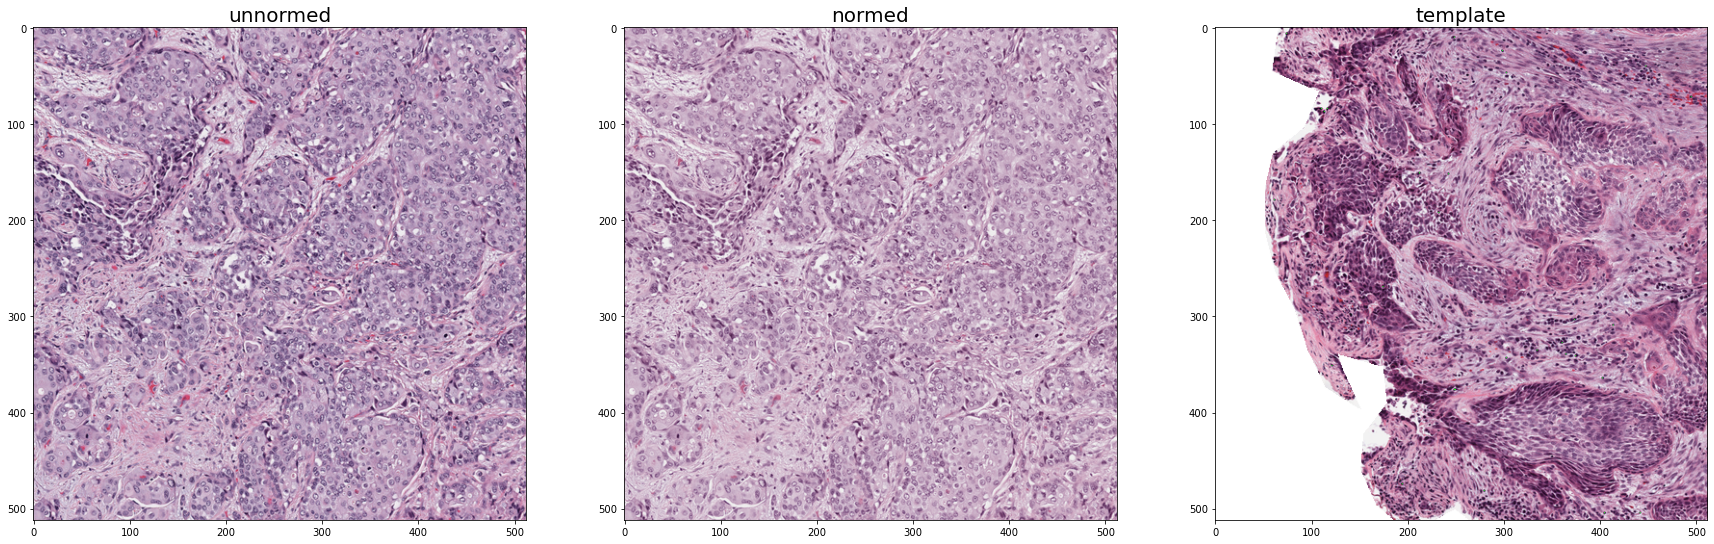

In [28]:
fig,axes = plt.subplots(1,3,figsize=(30,10))

fontdict = {'size':20}

ax1 = axes[0]
ax1.set_title('unnormed',fontdict=fontdict)
ax1.imshow(target_tile[1].get())

ax2 = axes[1]
ax2.set_title('normed',fontdict=fontdict)
ax2.imshow(normed[1].get()) #这里遇到cp.array在imshow中反应很慢的问题，使用.get（）或通过cp.asnumpy()将数组转化为np.array后进行展示

ax3 = axes[2]
ax3.set_title('template',fontdict = fontdict)
ax3.imshow(template_file)

## staintools

In [ ]:
# Read data
target = staintools.read_image(template_paths[27])
to_transform = staintools.read_image(target_paths[1])

# Standardize brightness (optional, can improve the tissue mask calculation)
target = staintools.LuminosityStandardizer.standardize(pixel_255(target,point=True))

# to_transform = staintools.LuminosityStandardizer.standardize(to_transform)

# # Stain normalize
normalizer = staintools.StainNormalizer(method='vahadane')
normalizer.fit(target)
transformed = normalizer.transform(to_transform)

normalizer1 = staintools.StainNormalizer(method='Macenko')
normalizer1.fit(target)
transformed1 = normalizer1.transform(to_transform)

ploting(1,4,figsize=(30,10),figseq=[to_transform,transformed,transformed1,target],title=['unnormed','V_normed','M_normed','template'])

### 验证两个工具CN效果是否相同

In [ ]:
# transformed == target_tile[1].get()  #由于staintools进行了luminostandardization两者不同
# show_info(tar= target_tile[1],trans=transformed)

### 找到比较好的template,用staintools做光标准化后挑一下

In [ ]:
# ploting(5,5,template_files[25:])

## 设置CN的路径

In [ ]:
# cases = glob.glob(f"/mnt/wangyh/TCGA_patches/*/*/")
# cn_path_test = '/home/wangyh/uro_biomarker/patho_AI/CN_test/'
# case = Path(cases[0])
# mag_40 = list(case.glob('*'))[0].name
# tiles = list(case.rglob('*/*'))
# tile = tiles[0]
# tile_name = str(tile).replace('/mnt/wangyh/TCGA_patches/',cn_path_test)



## COLOR NORMALIZATION

In [ ]:
# cases_select = cases[:10]

# mempool = cp.get_default_memory_pool()
# pinned_mempool = cp.get_default_pinned_memory_pool()

# template_paths = [i for i in gen_normal_size(glob.glob('/mnt/wangyh/TCGA_patches/H/d2e43ec6-5027-4f2c-932b-28a681da7cd9/5X/*.tiff'))]

# # Read data
# target = staintools.read_image(template_paths[27])

# # Standardize brightness (optional, can improve the tissue mask calculation)
# target = staintools.LuminosityStandardizer.standardize(pixel_255(target,point=True))

# # Stain normalize initializatino
# normalizer = staintools.StainNormalizer(method='vahadane')
# normalizer.fit(target)

# unnorm_tiles = []

# print(len(cases_select))
# for case in tqdm(cases_select):
#     label = Path(case).parent.name
#     tiles = list(Path(case).rglob("*/*"))
#     print(len(tiles))
#     try:
#         for tile in tiles:
#             try:
#                 tile_name = str(tile).replace('/mnt/wangyh/TCGA_patches/',cn_path_test)  #transformed tile的存放路径
#                 if not Path(tile_name).exists():
#                     if not Path(tile_name).parent.exists():
#                         Path(tile_name).parent.mkdir(parents=True)
                        
#                     tile_img = tif.imread(str(tile))  #读取to_transformed tile
#                     #if tile_img.shape[0] != 512 or tile_img.shape[1] != 512:
#                         #tile_img = Image.fromarray(np.uint8(tile_img)).resize((512,512),Image.ANTIALIAS)
#                         #tile_img = np.asarray(tile_img)
#                     #tile_name = str(tile).replace
#                    # tile_img = tif.imread(str(tile))
#                     #print(tile_img)
#                     lum_stand_tile = staintools.LuminosityStandardizer.standardize(pixel_255(tile_img,point=True))
#                     norm_imgs = normalizer.transform(lum_stand_tile)
# #                     tile_img = tile_img.reshape(1,512,512,3)
# #                     imgs = cp.asarray(tile_img,dtype=cp.float64)
# #                     norm_imgs= cp.asnumpy(normalizer.normalize(I=imgs))
# #                     norm_imgs = norm_imgs.reshape(512,512,3)
#                     tif.imsave(tile_name,norm_imgs)
#                    # Image.fromarray(np.uint8(norm_imgs)).save(tile_name)
#             except Exception as e:
#                     print(e)
#                     print(tile)
#                     unnorm_tiles.append(tile)
#             #norm_imgs = None
#             imgs = None
#             mempool.free_all_blocks() 
#             pinned_mempool.free_all_blocks()
#             gc.collect() 
     
#     except Exception as e:
#         print(e)
#         print(case) 
#         continue
# # np.save(f"{cn_path_test}.npy",np.asarray(unnorm_tiles))